In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import tempfile

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, \
                            precision_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow import keras

In [3]:
customer_data = pd.read_csv('../data-sources/customer-churn/customer-churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
customer_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)

In [5]:
le = LabelEncoder()

customer_data['Churn'] = le.fit_transform(customer_data['Churn'])

In [6]:
def ColumnTransformer(cell):
    if cell == 0:
        return 'No'
    else:
        return 'Yes'

customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].apply(ColumnTransformer)

In [7]:
def ColumnTransformer(cell):
    if cell == 'Electronic check':
        return 'ElCh'
    elif cell == 'Mailed check':
        return 'MaCh'
    elif cell == 'Bank transfer (automatic)':
        return 'BaTr-A'
    else:
        return 'CrCa-A'
    
customer_data['PaymentMethod'] = customer_data['PaymentMethod'].apply(ColumnTransformer)

In [8]:
customer_data.drop(customer_data[customer_data['Tenure'] == 0].index, inplace=True)
customer_data.drop('CustomerID', axis=1, inplace=True)

customer_data['TotalCharges'] = customer_data['TotalCharges'].astype(float)

In [9]:
print('Total: {}\n    Positive: {:.2f}\n    Negative: {:.2f}\n'.format(customer_data.shape[0],
                                                         customer_data['Churn'].value_counts(normalize=True)[1],
                                                         customer_data['Churn'].value_counts(normalize=True)[0]))

Total: 7032
    Positive: 0.27
    Negative: 0.73



In [10]:
target = customer_data.pop('Churn')

customer_data_dum = pd.get_dummies(customer_data, columns=customer_data.select_dtypes(include='object').columns,
                                                   drop_first=True)

customer_data_dum['Churn'] = target

In [11]:
train_data, test_data = train_test_split(customer_data_dum, test_size=0.2, stratify=customer_data_dum['Churn'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Churn'])

In [12]:
train_data.head()

,Tenure,MonthlyCharges,TotalCharges,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_CrCa-A,PaymentMethod_ElCh,PaymentMethod_MaCh,Churn
3478,23,78.55,1843.05,0,0,0,0,1,0,1,...,1,0,1,1,0,1,0,1,0,0
1365,59,41.05,2452.70,1,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
2172,1,43.95,43.95,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
772,1,19.90,19.90,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,1
1732,61,99.00,5969.30,1,1,1,1,1,0,1,...,1,0,1,1,0,0,0,1,0,0


In [13]:
train_labels = np.array(train_data.pop('Churn'))
bool_train_labels = train_labels != 0
validation_labels = np.array(validation_data.pop('Churn'))
test_labels = np.array(test_data.pop('Churn'))

train_features = np.array(train_data)
validation_features = np.array(validation_data)
test_features = np.array(test_data)

In [14]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', validation_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', validation_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4500,)
Validation labels shape: (1125,)
Test labels shape: (1407,)
Training features shape: (4500, 30)
Validation features shape: (1125, 30)
Test features shape: (1407, 30)


/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Negative distribution')

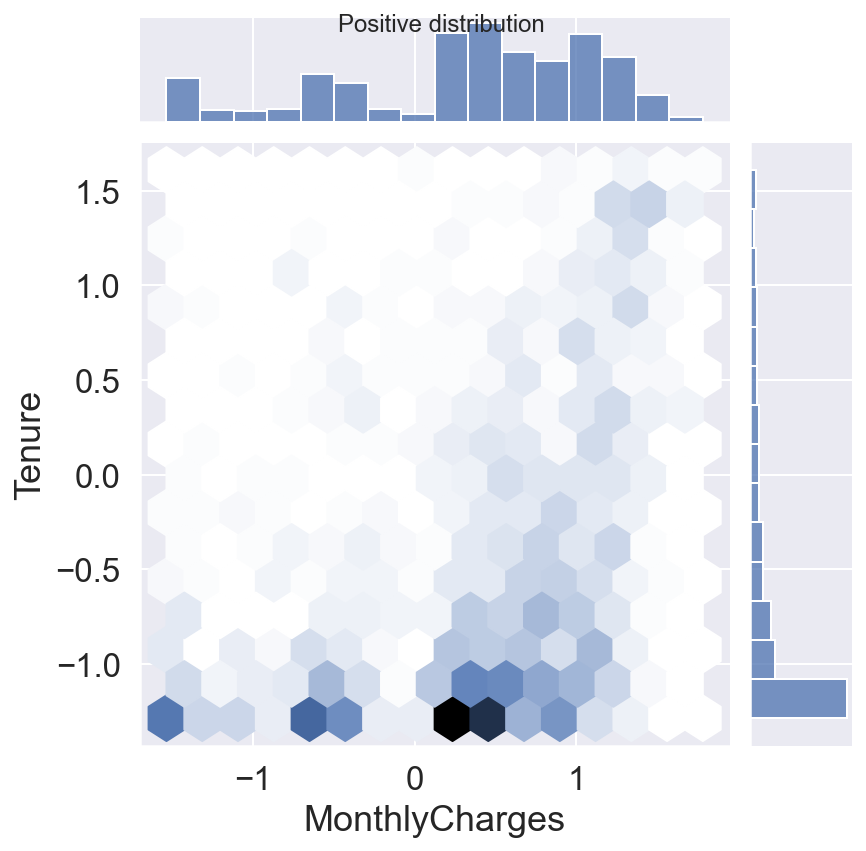

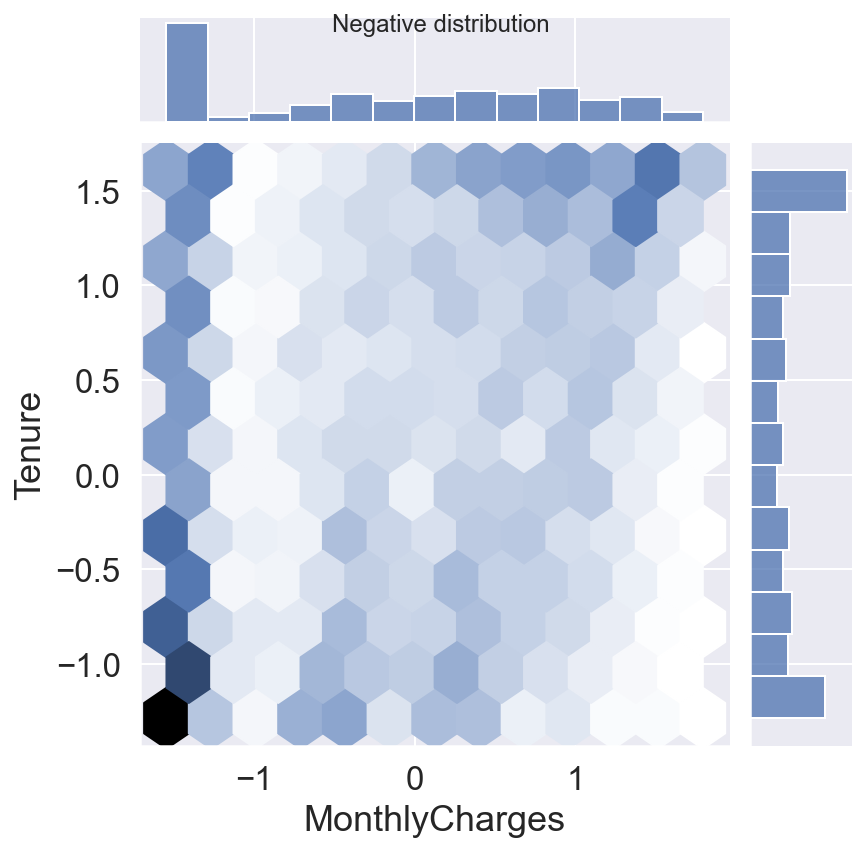

In [15]:
pos_data = pd.DataFrame(train_features[bool_train_labels], columns=train_data.columns)
neg_data = pd.DataFrame(train_features[~bool_train_labels], columns=train_data.columns)

sns.jointplot(pos_data['MonthlyCharges'], pos_data['Tenure'], kind='hex')
plt.suptitle('Positive distribution')

sns.jointplot(neg_data['MonthlyCharges'], neg_data['Tenure'], kind='hex')
plt.suptitle('Negative distribution')

In [16]:
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.AUC(name='prc', curve='PR'),]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.layers.Dense(24, activation='relu', input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.5),
                              keras.layers.Dense(16, activation='relu'),
                              keras.layers.Dropout(0.4),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias),
                             ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

In [17]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
                                                  verbose=1,
                                                  patience=10,
                                                  mode='max',
                                                  restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                744       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


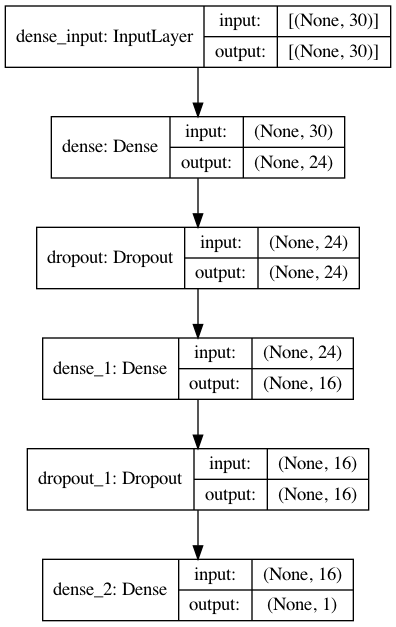

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB')

In [19]:
model.predict(train_features[:10])

array([[0.34757566],
       [0.24863246],
       [0.28345656],
       [0.10041496],
       [0.20012563],
       [0.3818052 ],
       [0.19911125],
       [0.22443938],
       [0.29549024],
       [0.26409948]], dtype=float32)

In [20]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.5215


In [21]:
neg, pos = np.bincount(customer_data_dum['Churn'])

total = neg + pos

initial_bias = np.log([pos/neg])
initial_bias

array([-1.01611428])

In [22]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.34891534],
       [0.1748223 ],
       [0.24216211],
       [0.8724941 ],
       [0.32753706],
       [0.29124707],
       [0.4439894 ],
       [0.39791352],
       [0.3684243 ],
       [0.46509096]], dtype=float32)

In [23]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.8448


In [24]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [25]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(train_features,
                              train_labels,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_data=(validation_features, validation_labels),
                              verbose=0)

In [26]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(train_features,
                                 train_labels,
                                 batch_size=BATCH_SIZE,
                                 epochs=20,
                                 validation_data=(validation_features, validation_labels),
                                 verbose=0)

In [27]:
def PlotLoss(history, label, color):
    plt.semilogy(history.epoch, history.history['loss'], color=color, label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=color, label='Validation ' + label, ls='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

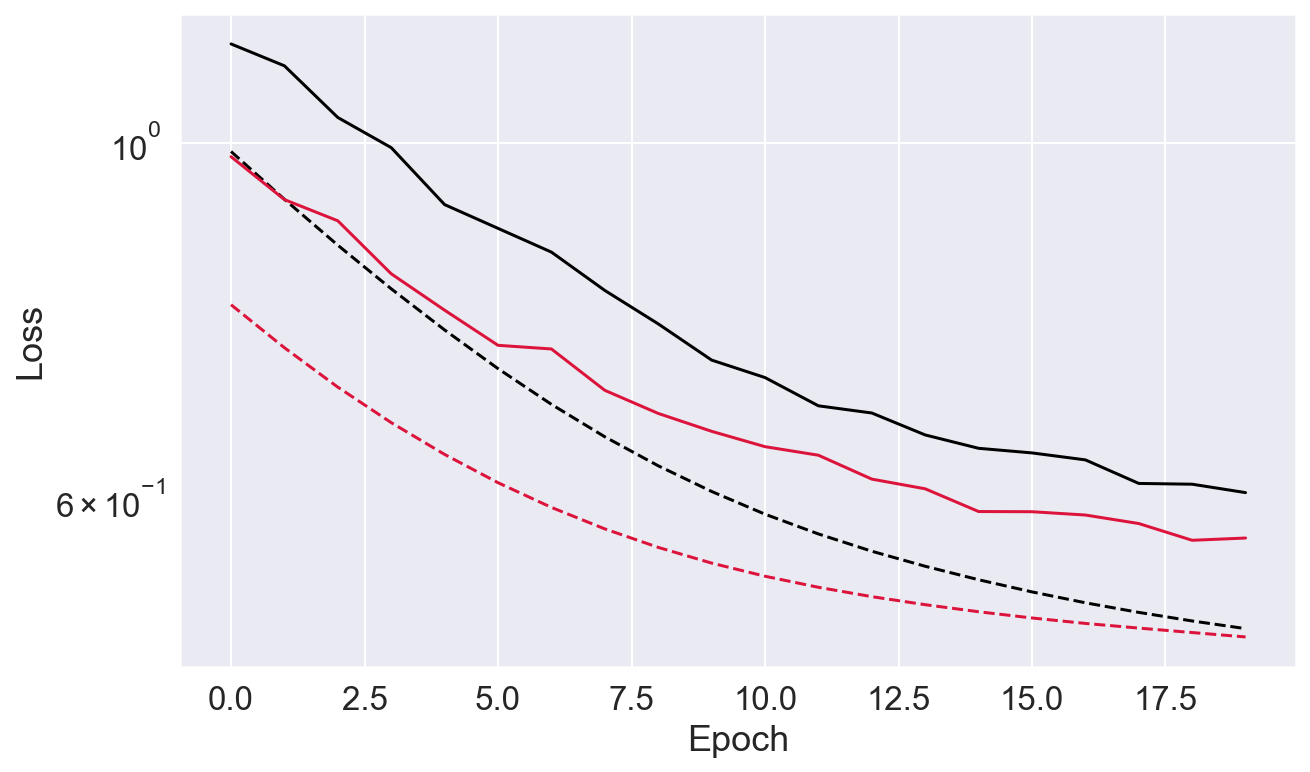

In [28]:
plt.figure(figsize=(10, 6))
PlotLoss(zero_bias_history, 'Zero Bias', 'black')
PlotLoss(careful_bias_history, 'Careful Bias', 'crimson')

In [29]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(validation_features, validation_labels))

Epoch 1/100
3/3 [==============================] - 2s 354ms/step - loss: 0.9842 - tp: 225.0000 - fp: 1025.0000 - tn: 3105.0000 - fn: 1270.0000 - accuracy: 0.5920 - precision: 0.1800 - recall: 0.1505 - auc: 0.4592 - prc: 0.2339 - val_loss: 0.7926 - val_tp: 24.0000 - val_fp: 221.0000 - val_tn: 605.0000 - val_fn: 275.0000 - val_accuracy: 0.5591 - val_precision: 0.0980 - val_recall: 0.0803 - val_auc: 0.3285 - val_prc: 0.2039
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 0.9327 - tp: 203.0000 - fp: 965.0000 - tn: 2339.0000 - fn: 993.0000 - accuracy: 0.5649 - precision: 0.1738 - recall: 0.1697 - auc: 0.3994 - prc: 0.2124 - val_loss: 0.7451 - val_tp: 23.0000 - val_fp: 200.0000 - val_tn: 626.0000 - val_fn: 276.0000 - val_accuracy: 0.5769 - val_precision: 0.1031 - val_recall: 0.0769 - val_auc: 0.3524 - val_prc: 0.2085
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.8610 - tp: 204.0000 - fp: 851.0000 - tn: 2453.0000 - fn: 992.0000 - accuracy: 0

3/3 [==============================] - 0s 14ms/step - loss: 0.5762 - tp: 217.0000 - fp: 328.0000 - tn: 2976.0000 - fn: 979.0000 - accuracy: 0.7096 - precision: 0.3982 - recall: 0.1814 - auc: 0.6455 - prc: 0.3667 - val_loss: 0.4957 - val_tp: 5.0000 - val_fp: 2.0000 - val_tn: 824.0000 - val_fn: 294.0000 - val_accuracy: 0.7369 - val_precision: 0.7143 - val_recall: 0.0167 - val_auc: 0.7870 - val_prc: 0.5256
Epoch 21/100
3/3 [==============================] - 0s 15ms/step - loss: 0.5666 - tp: 215.0000 - fp: 295.0000 - tn: 3009.0000 - fn: 981.0000 - accuracy: 0.7164 - precision: 0.4216 - recall: 0.1798 - auc: 0.6566 - prc: 0.3799 - val_loss: 0.4929 - val_tp: 7.0000 - val_fp: 2.0000 - val_tn: 824.0000 - val_fn: 292.0000 - val_accuracy: 0.7387 - val_precision: 0.7778 - val_recall: 0.0234 - val_auc: 0.7896 - val_prc: 0.5315
Epoch 22/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5541 - tp: 226.0000 - fp: 275.0000 - tn: 3029.0000 - fn: 970.0000 - accuracy: 0.7233 - precision: 

3/3 [==============================] - 0s 15ms/step - loss: 0.5159 - tp: 296.0000 - fp: 265.0000 - tn: 3039.0000 - fn: 900.0000 - accuracy: 0.7411 - precision: 0.5276 - recall: 0.2475 - auc: 0.7311 - prc: 0.4691 - val_loss: 0.4638 - val_tp: 21.0000 - val_fp: 10.0000 - val_tn: 816.0000 - val_fn: 278.0000 - val_accuracy: 0.7440 - val_precision: 0.6774 - val_recall: 0.0702 - val_auc: 0.8175 - val_prc: 0.5920
Epoch 40/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5257 - tp: 304.0000 - fp: 264.0000 - tn: 3040.0000 - fn: 892.0000 - accuracy: 0.7431 - precision: 0.5352 - recall: 0.2542 - auc: 0.7212 - prc: 0.4655 - val_loss: 0.4630 - val_tp: 22.0000 - val_fp: 11.0000 - val_tn: 815.0000 - val_fn: 277.0000 - val_accuracy: 0.7440 - val_precision: 0.6667 - val_recall: 0.0736 - val_auc: 0.8180 - val_prc: 0.5933
Epoch 41/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5129 - tp: 293.0000 - fp: 261.0000 - tn: 3043.0000 - fn: 903.0000 - accuracy: 0.7413 - precisi

3/3 [==============================] - 0s 13ms/step - loss: 0.4994 - tp: 338.0000 - fp: 260.0000 - tn: 3044.0000 - fn: 858.0000 - accuracy: 0.7516 - precision: 0.5652 - recall: 0.2826 - auc: 0.7629 - prc: 0.4957 - val_loss: 0.4519 - val_tp: 43.0000 - val_fp: 15.0000 - val_tn: 811.0000 - val_fn: 256.0000 - val_accuracy: 0.7591 - val_precision: 0.7414 - val_recall: 0.1438 - val_auc: 0.8284 - val_prc: 0.6081
Epoch 59/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4916 - tp: 349.0000 - fp: 241.0000 - tn: 3063.0000 - fn: 847.0000 - accuracy: 0.7582 - precision: 0.5915 - recall: 0.2918 - auc: 0.7661 - prc: 0.5263 - val_loss: 0.4517 - val_tp: 42.0000 - val_fp: 15.0000 - val_tn: 811.0000 - val_fn: 257.0000 - val_accuracy: 0.7582 - val_precision: 0.7368 - val_recall: 0.1405 - val_auc: 0.8291 - val_prc: 0.6103
Epoch 60/100
3/3 [==============================] - 0s 13ms/step - loss: 0.4883 - tp: 349.0000 - fp: 263.0000 - tn: 3041.0000 - fn: 847.0000 - accuracy: 0.7533 - precisi

3/3 [==============================] - 0s 14ms/step - loss: 0.4772 - tp: 384.0000 - fp: 238.0000 - tn: 3066.0000 - fn: 812.0000 - accuracy: 0.7667 - precision: 0.6174 - recall: 0.3211 - auc: 0.7876 - prc: 0.5533 - val_loss: 0.4451 - val_tp: 59.0000 - val_fp: 21.0000 - val_tn: 805.0000 - val_fn: 240.0000 - val_accuracy: 0.7680 - val_precision: 0.7375 - val_recall: 0.1973 - val_auc: 0.8338 - val_prc: 0.6189
Epoch 78/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4816 - tp: 395.0000 - fp: 251.0000 - tn: 3053.0000 - fn: 801.0000 - accuracy: 0.7662 - precision: 0.6115 - recall: 0.3303 - auc: 0.7801 - prc: 0.5412 - val_loss: 0.4447 - val_tp: 59.0000 - val_fp: 21.0000 - val_tn: 805.0000 - val_fn: 240.0000 - val_accuracy: 0.7680 - val_precision: 0.7375 - val_recall: 0.1973 - val_auc: 0.8340 - val_prc: 0.6188
Epoch 79/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4798 - tp: 395.0000 - fp: 220.0000 - tn: 3084.0000 - fn: 801.0000 - accuracy: 0.7731 - precisi

3/3 [==============================] - 0s 14ms/step - loss: 0.4699 - tp: 385.0000 - fp: 241.0000 - tn: 3063.0000 - fn: 811.0000 - accuracy: 0.7662 - precision: 0.6150 - recall: 0.3219 - auc: 0.7941 - prc: 0.5565 - val_loss: 0.4408 - val_tp: 67.0000 - val_fp: 24.0000 - val_tn: 802.0000 - val_fn: 232.0000 - val_accuracy: 0.7724 - val_precision: 0.7363 - val_recall: 0.2241 - val_auc: 0.8373 - val_prc: 0.6227
Epoch 97/100
3/3 [==============================] - 0s 13ms/step - loss: 0.4632 - tp: 404.0000 - fp: 234.0000 - tn: 3070.0000 - fn: 792.0000 - accuracy: 0.7720 - precision: 0.6332 - recall: 0.3378 - auc: 0.8001 - prc: 0.5733 - val_loss: 0.4405 - val_tp: 67.0000 - val_fp: 24.0000 - val_tn: 802.0000 - val_fn: 232.0000 - val_accuracy: 0.7724 - val_precision: 0.7363 - val_recall: 0.2241 - val_auc: 0.8375 - val_prc: 0.6234
Epoch 98/100
3/3 [==============================] - 0s 13ms/step - loss: 0.4752 - tp: 392.0000 - fp: 230.0000 - tn: 3074.0000 - fn: 804.0000 - accuracy: 0.7702 - precisi

In [30]:
def PlotMetrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    plt.figure(figsize=(15, 15))
    for n, metric in enumerate(metrics):
        name = metric.replace('_', ' ').capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color='black', label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], color='black', ls='--', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

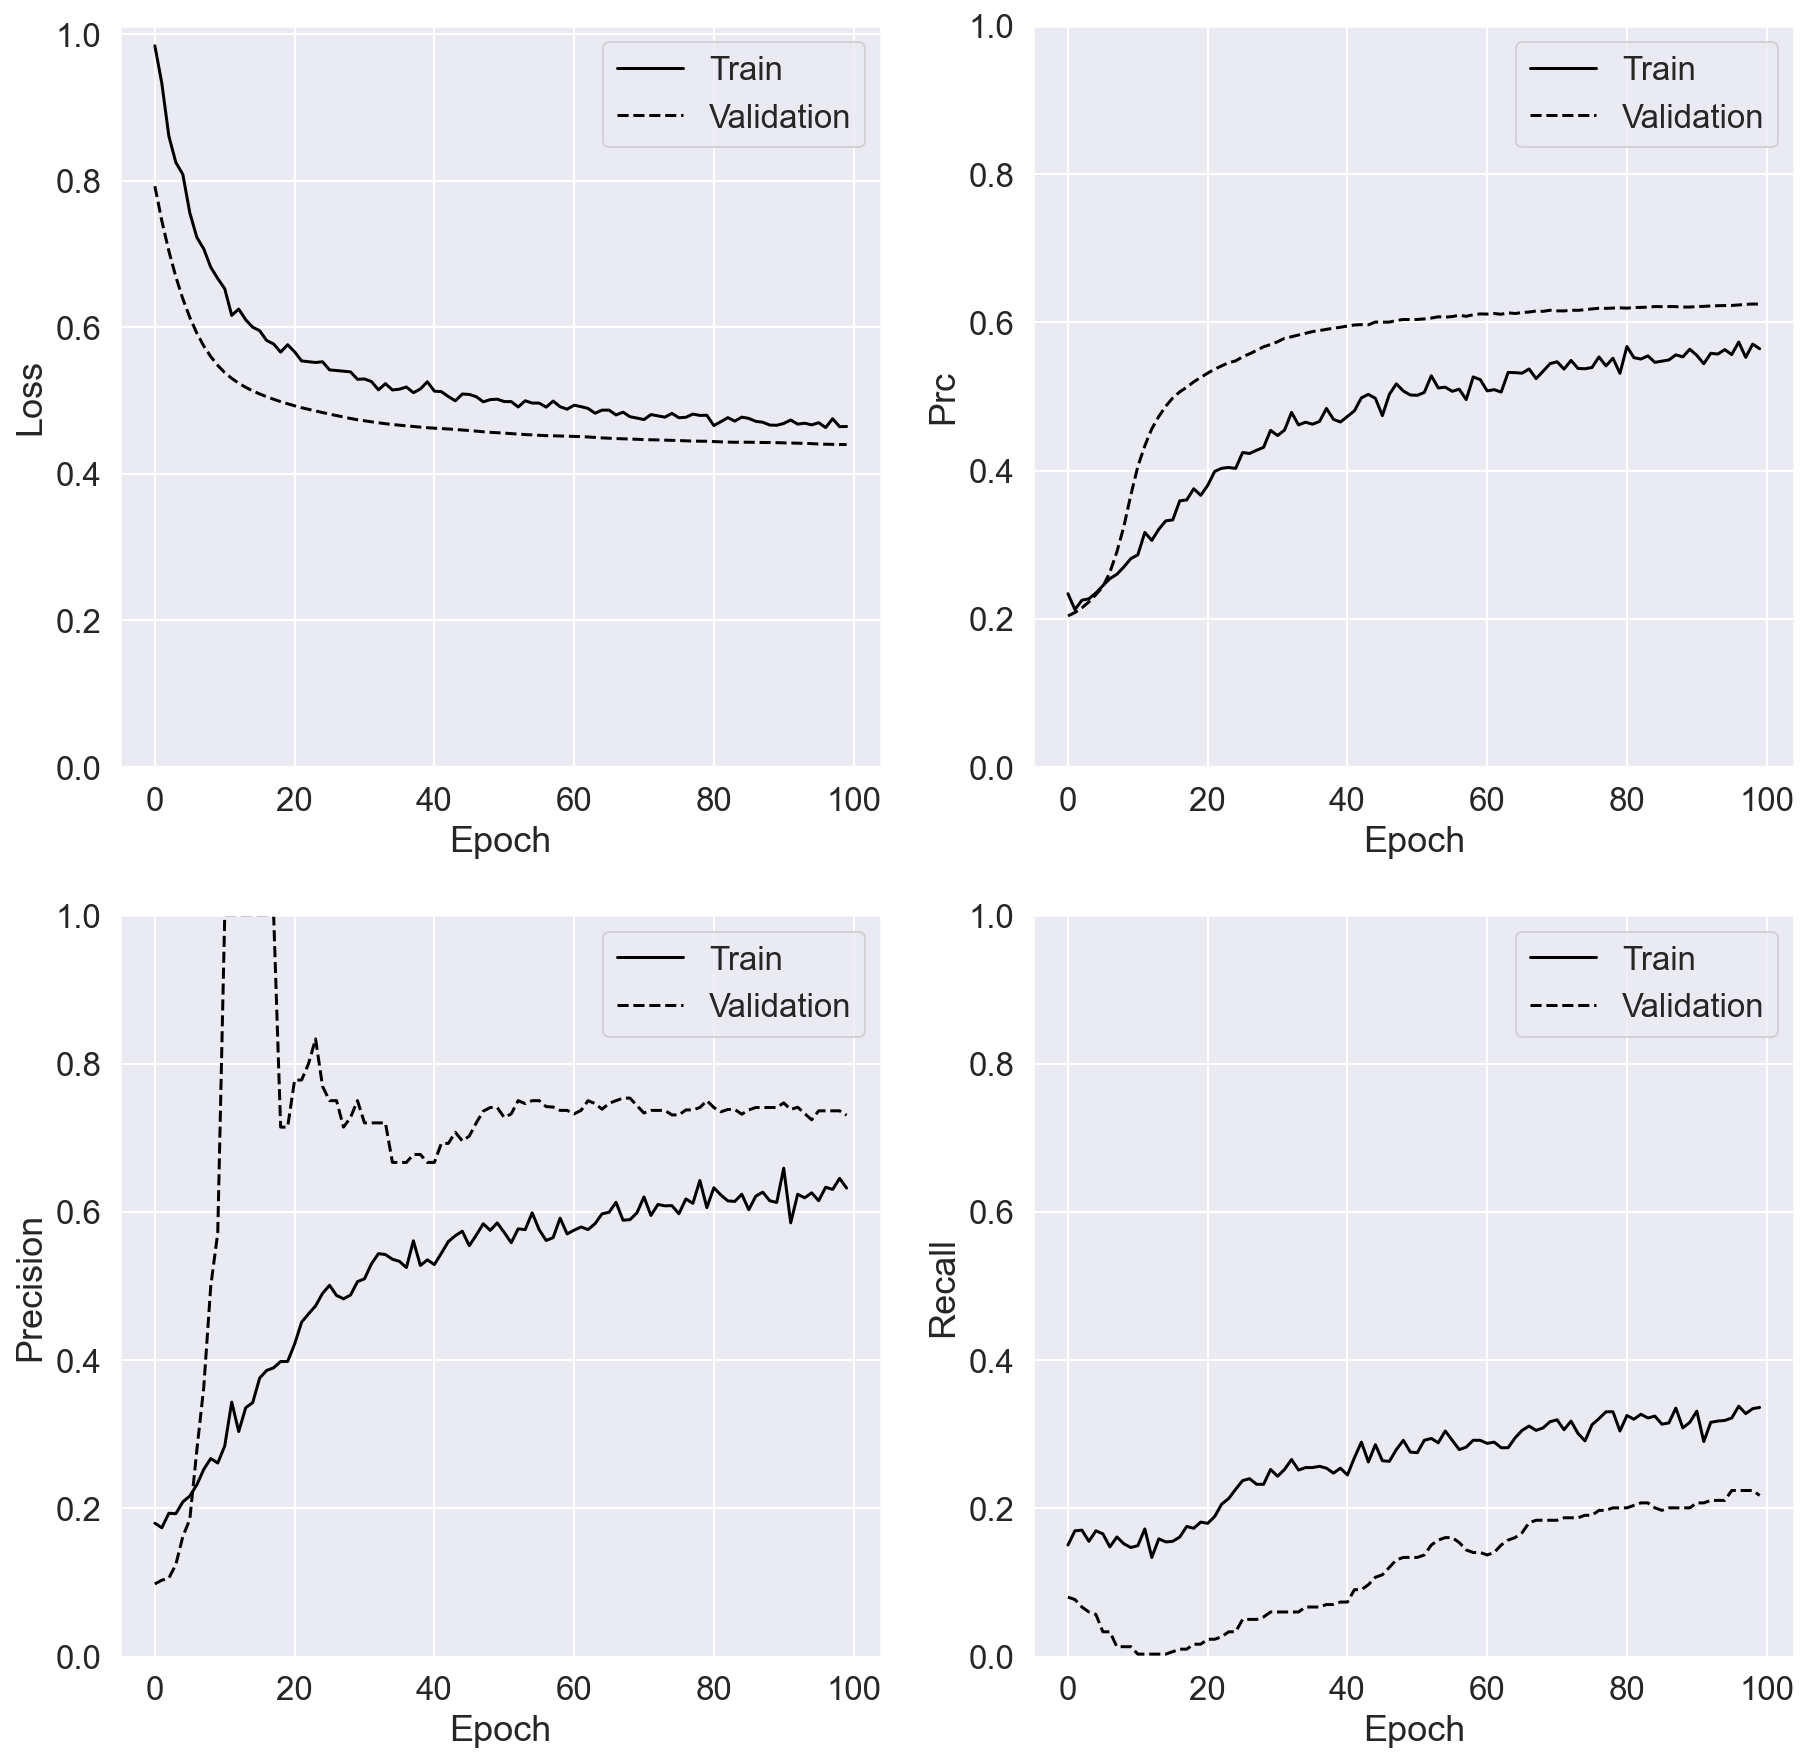

In [31]:
PlotMetrics(baseline_history)

In [32]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [33]:
def ConfMatrix(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

loss :  0.4455881714820862
tp :  85.0
fp :  22.0
tn :  1011.0
fn :  289.0
accuracy :  0.7789623141288757
precision :  0.7943925261497498
recall :  0.22727273404598236
auc :  0.8281159996986389
prc :  0.6197153925895691


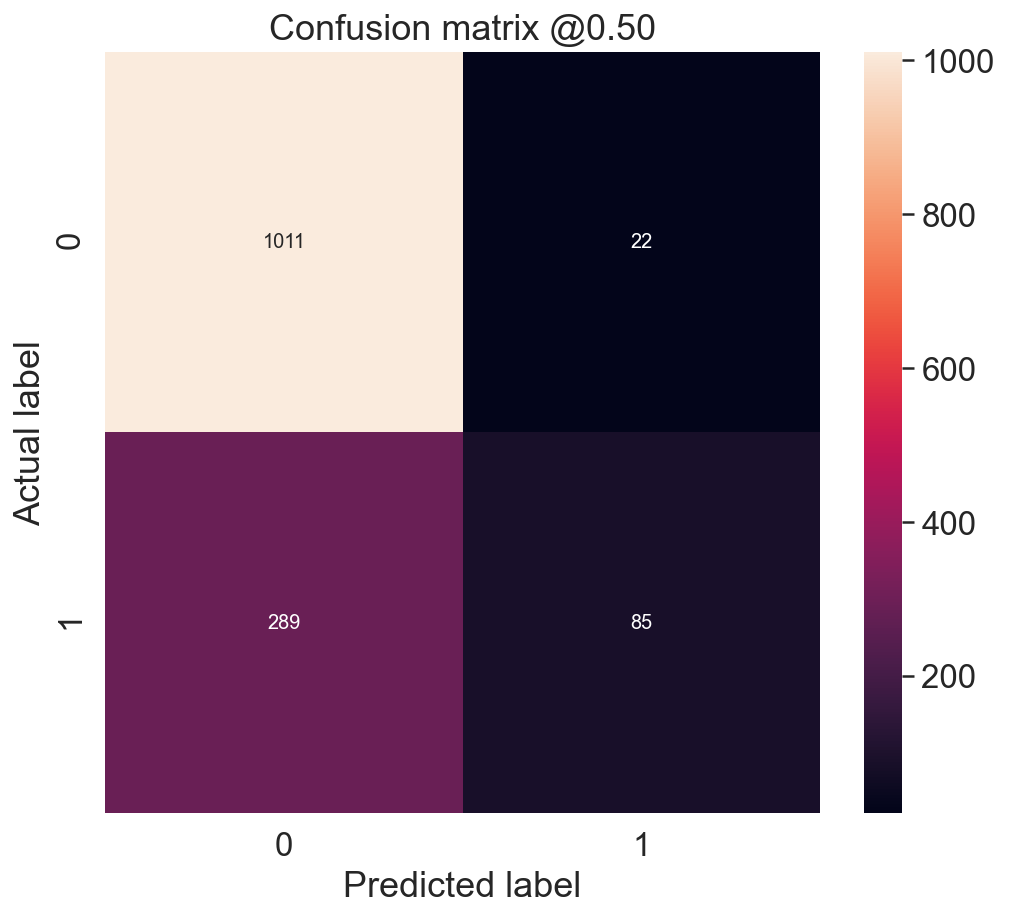

In [34]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_baseline)

In [35]:
def PlotROC(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, lw=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 100.5])
    plt.ylim([-0.5, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

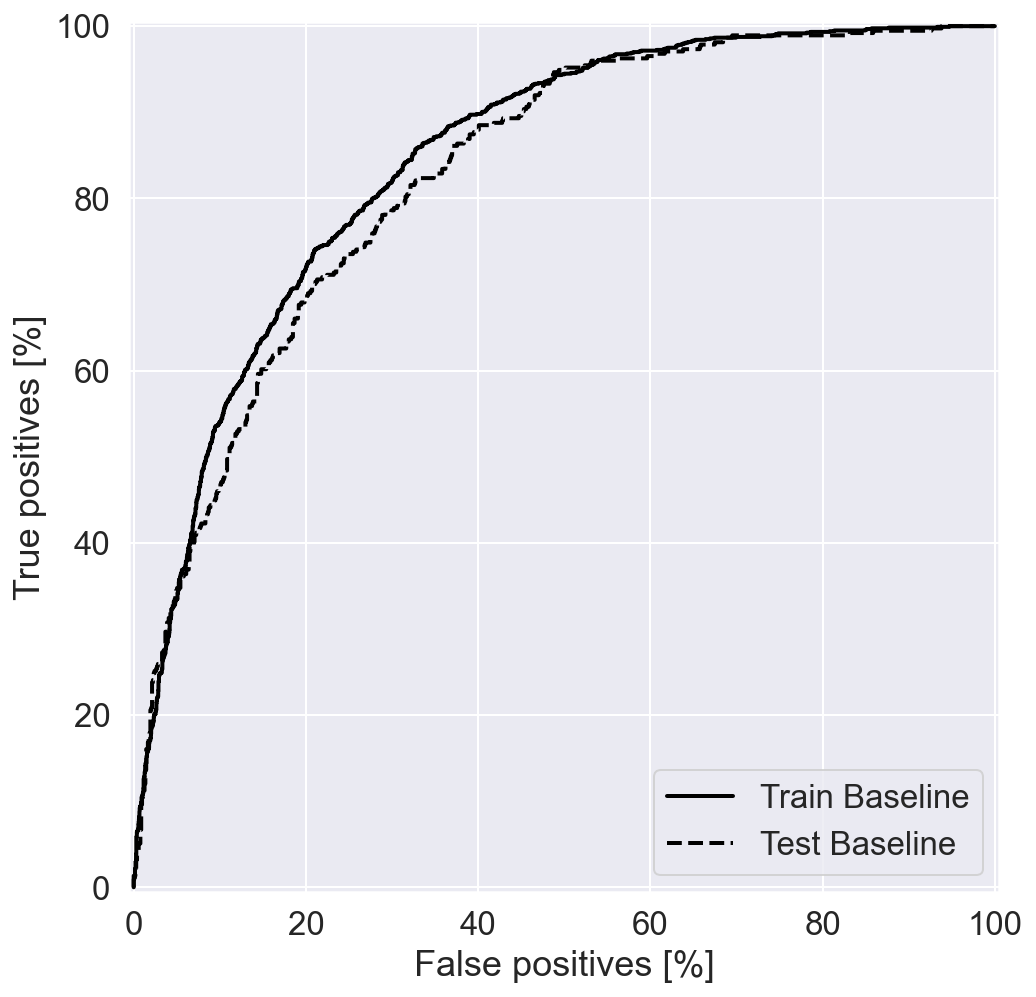

In [36]:
plt.figure(figsize=(8, 8))
PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower right')

In [37]:
def PlotPRC(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, lw=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

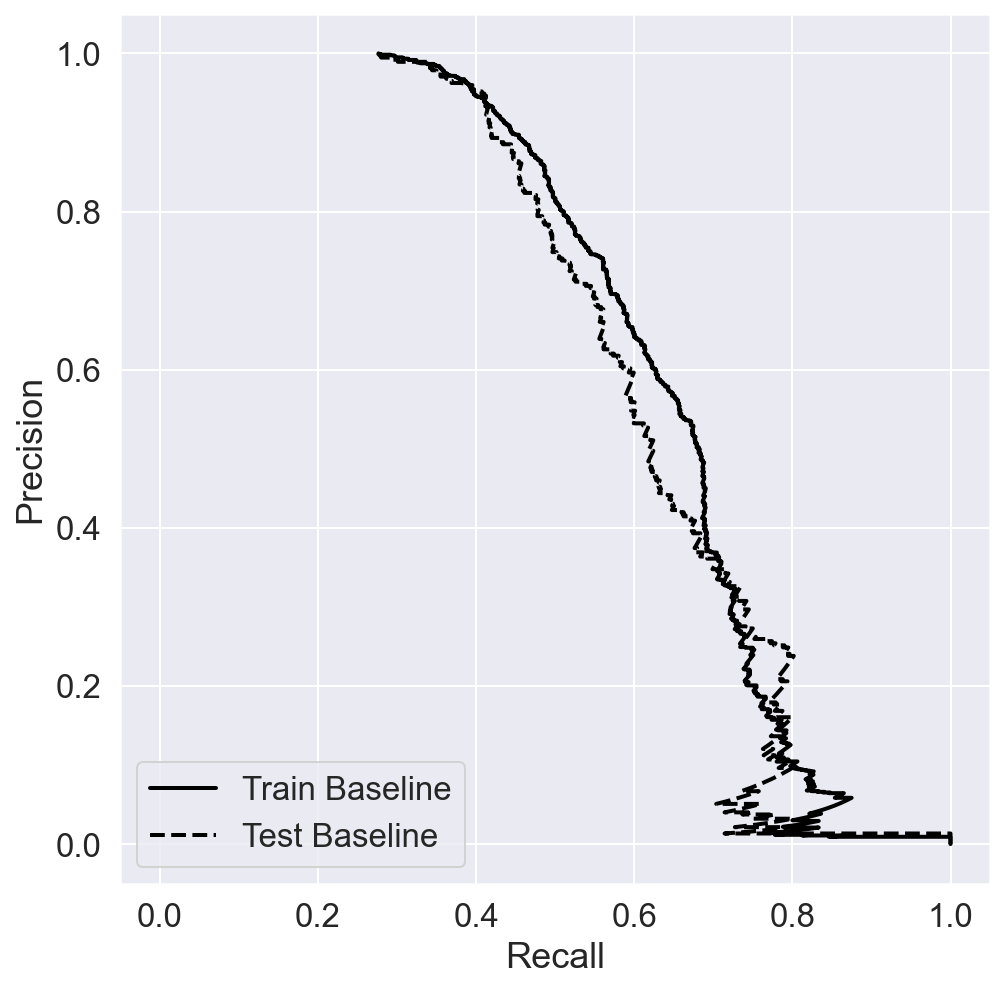

In [38]:
plt.figure(figsize=(8, 8))
PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower left')

In [39]:
weight_for_0 = (1/neg)*(total/2)
weight_for_1 = (1/pos)*(total/2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


In [40]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features,
                                      train_labels,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      callbacks=[early_stopping],
                                      validation_data=(validation_features, validation_labels),
                                      class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
3/3 [==============================] - 2s 384ms/step - loss: 1.1454 - tp: 311.0000 - fp: 1068.0000 - tn: 3269.0000 - fn: 1259.0000 - accuracy: 0.6061 - precision: 0.2255 - recall: 0.1981 - auc: 0.5023 - prc: 0.2494 - val_loss: 0.8006 - val_tp: 27.0000 - val_fp: 236.0000 - val_tn: 590.0000 - val_fn: 272.0000 - val_accuracy: 0.5484 - val_precision: 0.1027 - val_recall: 0.0903 - val_auc: 0.3256 - val_prc: 0.2040
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 1.0795 - tp: 258.0000 - fp: 1052.0000 - tn: 2252.0000 - fn: 938.0000 - accuracy: 0.5578 - precision: 0.1969 - recall: 0.2157 - auc: 0.4287 - prc: 0.2231 - val_loss: 0.7599 - val_tp: 26.0000 - val_fp: 227.0000 - val_tn: 599.0000 - val_fn: 273.0000 - val_accuracy: 0.5556 - val_precision: 0.1028 - val_recall: 0.0870 - val_auc: 0.3478 - val_prc: 0.2079
Epoch 3/100
3/

3/3 [==============================] - 0s 14ms/step - loss: 0.6972 - tp: 599.0000 - fp: 958.0000 - tn: 2346.0000 - fn: 597.0000 - accuracy: 0.6544 - precision: 0.3847 - recall: 0.5008 - auc: 0.6543 - prc: 0.4042 - val_loss: 0.5376 - val_tp: 197.0000 - val_fp: 172.0000 - val_tn: 654.0000 - val_fn: 102.0000 - val_accuracy: 0.7564 - val_precision: 0.5339 - val_recall: 0.6589 - val_auc: 0.7963 - val_prc: 0.5495
Epoch 20/100
3/3 [==============================] - 0s 14ms/step - loss: 0.7040 - tp: 599.0000 - fp: 985.0000 - tn: 2319.0000 - fn: 597.0000 - accuracy: 0.6484 - precision: 0.3782 - recall: 0.5008 - auc: 0.6494 - prc: 0.4061 - val_loss: 0.5350 - val_tp: 197.0000 - val_fp: 177.0000 - val_tn: 649.0000 - val_fn: 102.0000 - val_accuracy: 0.7520 - val_precision: 0.5267 - val_recall: 0.6589 - val_auc: 0.7992 - val_prc: 0.5561
Epoch 21/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6908 - tp: 622.0000 - fp: 961.0000 - tn: 2343.0000 - fn: 574.0000 - accuracy: 0.6589 - pre

3/3 [==============================] - 0s 13ms/step - loss: 0.6366 - tp: 654.0000 - fp: 827.0000 - tn: 2477.0000 - fn: 542.0000 - accuracy: 0.6958 - precision: 0.4416 - recall: 0.5468 - auc: 0.7232 - prc: 0.4677 - val_loss: 0.5071 - val_tp: 212.0000 - val_fp: 183.0000 - val_tn: 643.0000 - val_fn: 87.0000 - val_accuracy: 0.7600 - val_precision: 0.5367 - val_recall: 0.7090 - val_auc: 0.8218 - val_prc: 0.6091
Epoch 39/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6090 - tp: 714.0000 - fp: 820.0000 - tn: 2484.0000 - fn: 482.0000 - accuracy: 0.7107 - precision: 0.4654 - recall: 0.5970 - auc: 0.7442 - prc: 0.5029 - val_loss: 0.5067 - val_tp: 212.0000 - val_fp: 183.0000 - val_tn: 643.0000 - val_fn: 87.0000 - val_accuracy: 0.7600 - val_precision: 0.5367 - val_recall: 0.7090 - val_auc: 0.8223 - val_prc: 0.6098
Epoch 40/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6146 - tp: 679.0000 - fp: 793.0000 - tn: 2511.0000 - fn: 517.0000 - accuracy: 0.7089 - preci

3/3 [==============================] - 0s 13ms/step - loss: 0.5944 - tp: 746.0000 - fp: 758.0000 - tn: 2546.0000 - fn: 450.0000 - accuracy: 0.7316 - precision: 0.4960 - recall: 0.6237 - auc: 0.7649 - prc: 0.4964 - val_loss: 0.4955 - val_tp: 215.0000 - val_fp: 180.0000 - val_tn: 646.0000 - val_fn: 84.0000 - val_accuracy: 0.7653 - val_precision: 0.5443 - val_recall: 0.7191 - val_auc: 0.8309 - val_prc: 0.6184
Epoch 58/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5834 - tp: 737.0000 - fp: 780.0000 - tn: 2524.0000 - fn: 459.0000 - accuracy: 0.7247 - precision: 0.4858 - recall: 0.6162 - auc: 0.7712 - prc: 0.5223 - val_loss: 0.4950 - val_tp: 214.0000 - val_fp: 180.0000 - val_tn: 646.0000 - val_fn: 85.0000 - val_accuracy: 0.7644 - val_precision: 0.5431 - val_recall: 0.7157 - val_auc: 0.8309 - val_prc: 0.6190
Epoch 59/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5917 - tp: 725.0000 - fp: 760.0000 - tn: 2544.0000 - fn: 471.0000 - accuracy: 0.7264 - preci

3/3 [==============================] - 0s 14ms/step - loss: 0.5665 - tp: 751.0000 - fp: 730.0000 - tn: 2574.0000 - fn: 445.0000 - accuracy: 0.7389 - precision: 0.5071 - recall: 0.6279 - auc: 0.7880 - prc: 0.5432 - val_loss: 0.4898 - val_tp: 219.0000 - val_fp: 179.0000 - val_tn: 647.0000 - val_fn: 80.0000 - val_accuracy: 0.7698 - val_precision: 0.5503 - val_recall: 0.7324 - val_auc: 0.8355 - val_prc: 0.6228
Epoch 77/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5681 - tp: 754.0000 - fp: 714.0000 - tn: 2590.0000 - fn: 442.0000 - accuracy: 0.7431 - precision: 0.5136 - recall: 0.6304 - auc: 0.7888 - prc: 0.5497 - val_loss: 0.4889 - val_tp: 219.0000 - val_fp: 179.0000 - val_tn: 647.0000 - val_fn: 80.0000 - val_accuracy: 0.7698 - val_precision: 0.5503 - val_recall: 0.7324 - val_auc: 0.8358 - val_prc: 0.6226
Epoch 78/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5645 - tp: 745.0000 - fp: 721.0000 - tn: 2583.0000 - fn: 451.0000 - accuracy: 0.7396 - preci

3/3 [==============================] - 0s 15ms/step - loss: 0.5596 - tp: 759.0000 - fp: 746.0000 - tn: 2558.0000 - fn: 437.0000 - accuracy: 0.7371 - precision: 0.5043 - recall: 0.6346 - auc: 0.7944 - prc: 0.5543 - val_loss: 0.4874 - val_tp: 221.0000 - val_fp: 185.0000 - val_tn: 641.0000 - val_fn: 78.0000 - val_accuracy: 0.7662 - val_precision: 0.5443 - val_recall: 0.7391 - val_auc: 0.8380 - val_prc: 0.6308
Epoch 96/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5575 - tp: 773.0000 - fp: 734.0000 - tn: 2570.0000 - fn: 423.0000 - accuracy: 0.7429 - precision: 0.5129 - recall: 0.6463 - auc: 0.7939 - prc: 0.5545 - val_loss: 0.4867 - val_tp: 221.0000 - val_fp: 186.0000 - val_tn: 640.0000 - val_fn: 78.0000 - val_accuracy: 0.7653 - val_precision: 0.5430 - val_recall: 0.7391 - val_auc: 0.8381 - val_prc: 0.6315
Epoch 97/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5632 - tp: 761.0000 - fp: 730.0000 - tn: 2574.0000 - fn: 435.0000 - accuracy: 0.7411 - preci

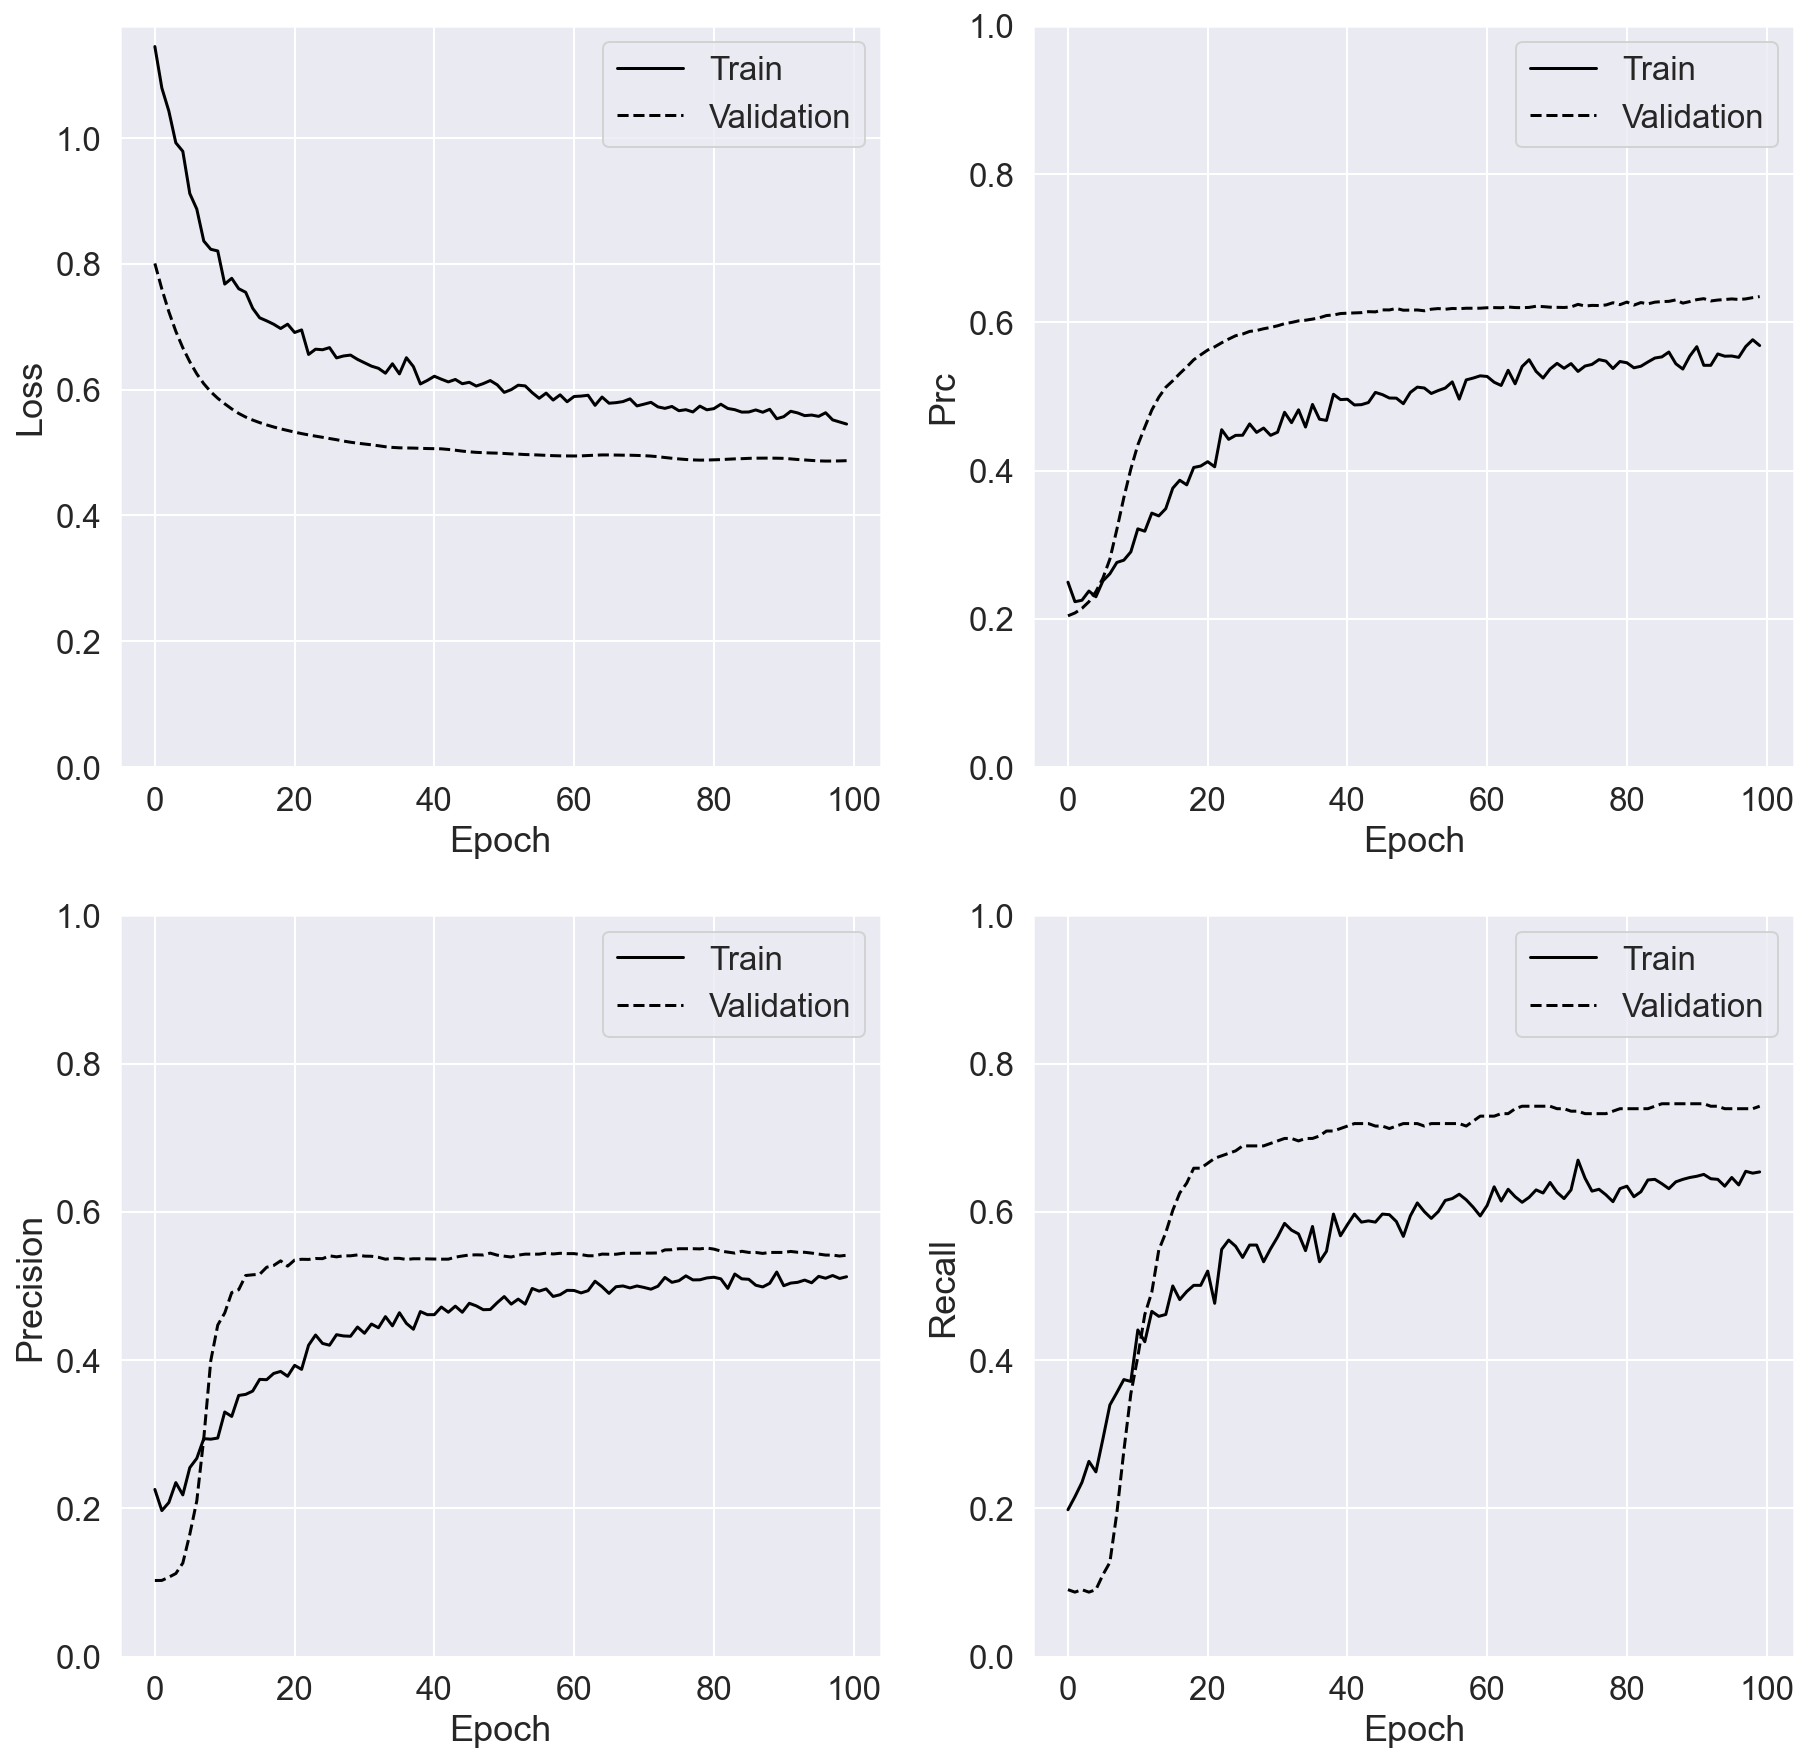

In [41]:
PlotMetrics(weighted_history)

In [42]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.4877837598323822
tp :  264.0
fp :  227.0
tn :  806.0
fn :  110.0
accuracy :  0.7604833245277405
precision :  0.5376781821250916
recall :  0.7058823704719543
auc :  0.8299098014831543
prc :  0.631154477596283


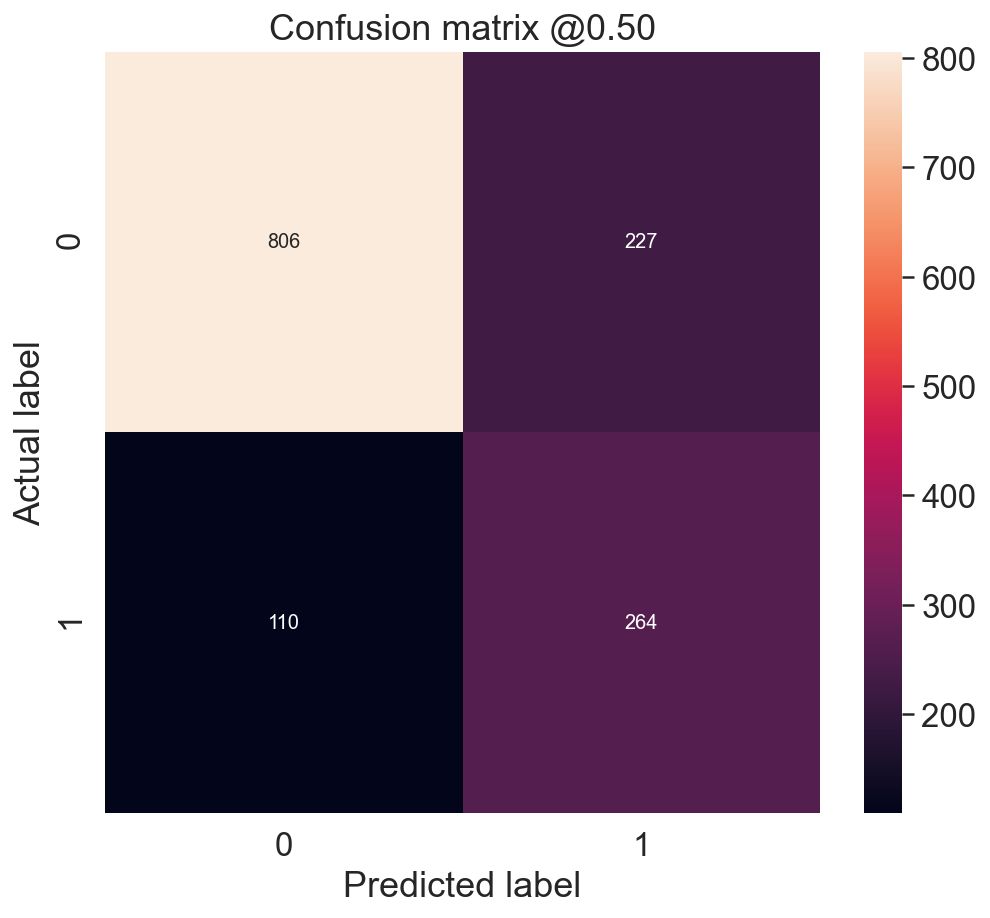

In [43]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_weighted)

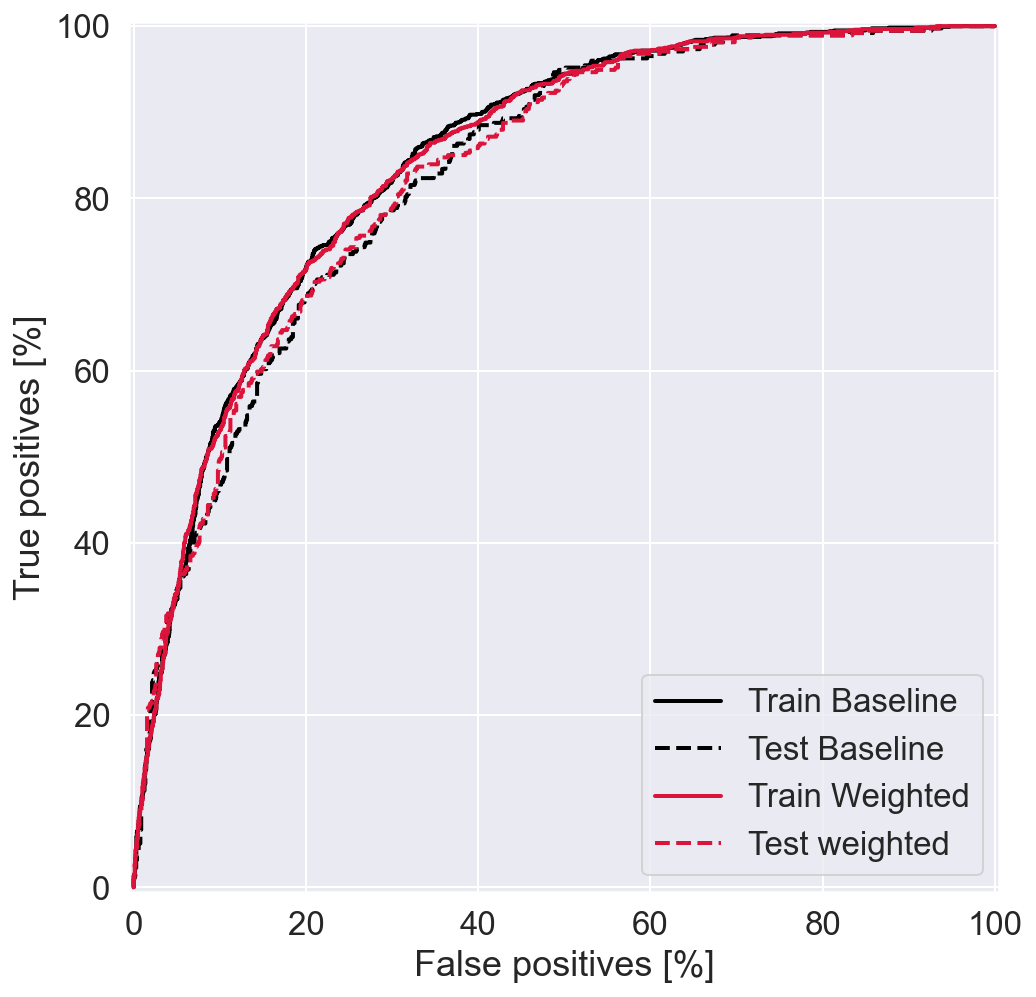

In [44]:
plt.figure(figsize=(8, 8))

PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotROC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotROC('Test weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower right')

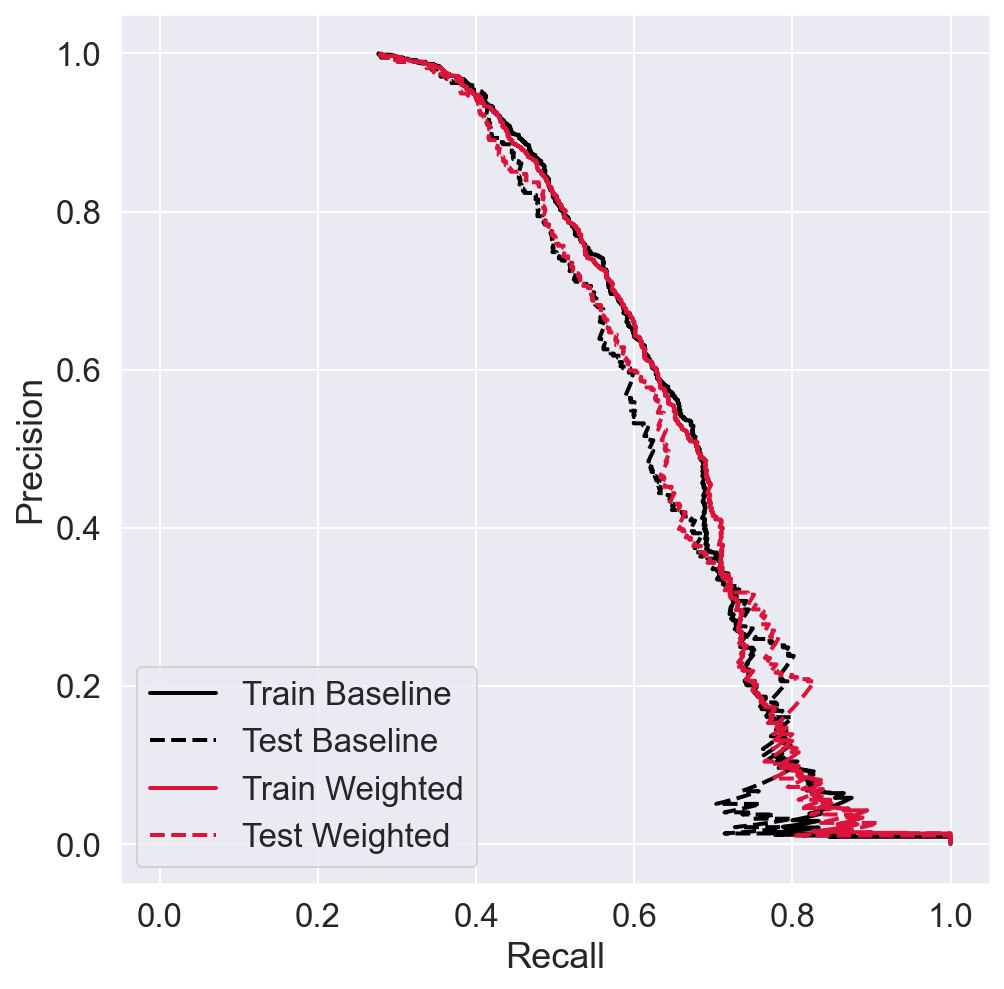

In [45]:
plt.figure(figsize=(8, 8))

PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotPRC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotPRC('Test Weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower left')